 ## Financial Transaction Classifier  ##

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("transactions.csv")
df.shape

(314, 6)

In [5]:
df = df.dropna(subset=['clean_description', 'category'])
# df.shape  (313, 6)

In [6]:
def clean_text(text):

    if not isinstance(text, str):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z0-9\s]', ' ', text)  # remove punctuation & special chars
    text = re.sub(r'\s+', ' ', text)  # collapse multiple spaces
    text = text.strip()
    return text


# Apply cleaning
df['clean_description2'] = df['clean_description'].apply(clean_text)

# print(df[['clean_description2', 'clean_description', 'category']]


In [7]:
df['tokens2'] = df['clean_description2'].str.lower().str.split()

from collections import Counter

all_tokens2 = [token for tokens in df['tokens2'] for token in tokens]
token_counts2 = Counter(all_tokens2)

threshold = 3
common_tokens2 = {token for token, count in token_counts2.items() if count >= threshold}

vocab_dict2 = {token: idx + 1 for idx, token in enumerate(sorted(common_tokens2))}

In [8]:
def text_to_indices(text, vocab_dict):
    tokens = text.lower().split()
    return [vocab_dict.get(token, 0) for token in tokens]  # 0 for unknowns

df['sequence2'] = df['clean_description2'].apply(lambda x: text_to_indices(x, vocab_dict2))


In [9]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 12  # based on your earlier analysis
X_seq2 = pad_sequences(df['sequence2'], maxlen=MAX_LEN, padding='post', truncating='post')


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['category'])  # or whatever your label column is


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq2, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy:", clf.score(X_test, y_test))


Accuracy: 0.9206349206349206


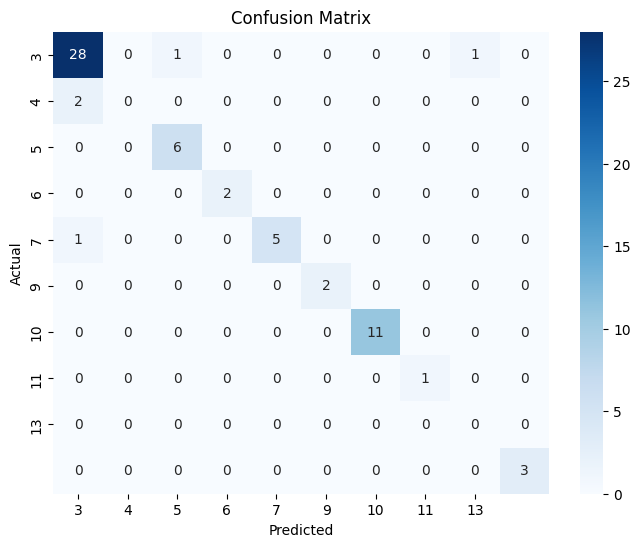

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume y_test, y_pred are your test labels and predictions
cm = confusion_matrix(y_test, y_pred)

# Unique classes present in y_test
classes_present = sorted(np.unique(y_test))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_present,
            yticklabels=classes_present)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           3       0.90      0.93      0.92        30
           4       0.00      0.00      0.00         2
           5       0.86      1.00      0.92         6
           6       1.00      1.00      1.00         2
           7       1.00      0.83      0.91         6
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         0
          13       1.00      1.00      1.00         3

    accuracy                           0.92        63
   macro avg       0.78      0.78      0.78        63
weighted avg       0.91      0.92      0.91        63



/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

In [15]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

print("XGBoost Accuracy:", xgb_clf.score(X_test, y_test))


/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:47:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9047619047619048


In [23]:
# Make sure keys and values are integers
# Convert keys to int first
inv_vocab_dict = {v: k for k, v in vocab_dict2.items()}


print("Top 20 important features:")
for idx in indices:
    token = inv_vocab_dict.get(idx, "UNK")
    print(f"{token}: {importances[idx]:.4f}")


Top 20 important features:
04: 0.1911
05: 0.1643
06: 0.1185
00: 0.0982
001: 0.0952
01: 0.0859
03: 0.0799
0: 0.0540
07: 0.0413
UNK: 0.0372
02: 0.0210
08: 0.0132


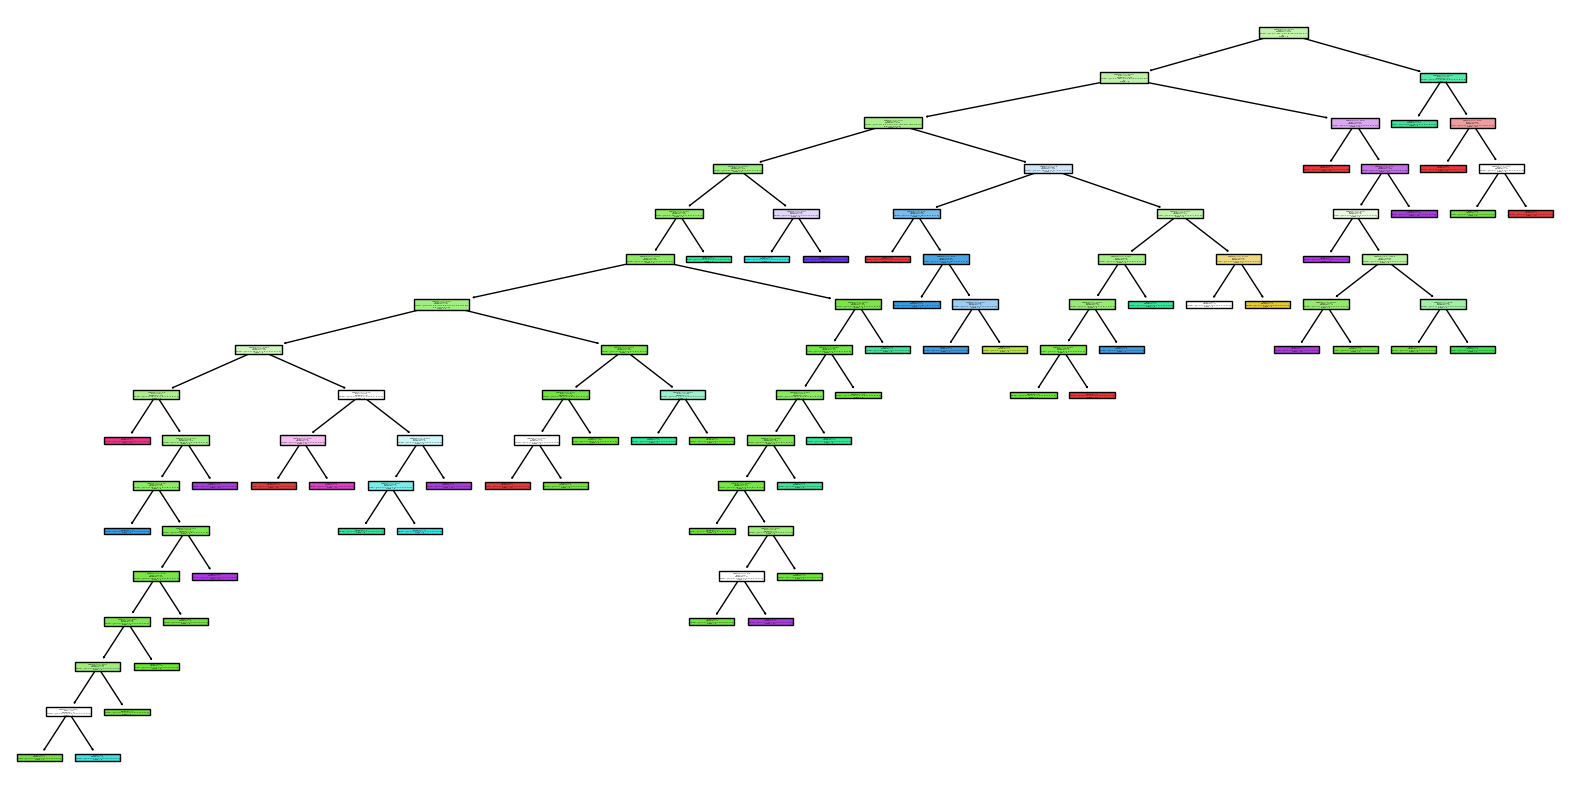

In [55]:
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
class_names = [str(c) for c in clf.classes_]  # class labels as strings

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

estimator = clf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(estimator, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()


In [59]:
import shap

# Assume clf is your trained model, X_train your training data (as DataFrame or numpy)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

# Summary plot for global feature importance
# shap.summary_plot(shap_values, X_train)

# For a specific instance, e.g. first test sample
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0])
